# 作业2: 频繁模式与关联规则挖掘
3220211009 郭镇远

Github:https://github.com/Relwayg/Data-Mining/work2_frequent_pattens.ipynb

In [238]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns 

## 1.问题描述
选择数据集进行频繁模式和关联规则挖掘
### 1.1 问题要求
- 对数据集进行处理，转换成适合进行关联规则挖掘的形式
- 找出频繁模式
- 导出关联规则，计算其支持度和置信度
- 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种
- 对挖掘结果进行分析
- 可视化展示
### 1.2 数据集
使用Melbourne Airbnb Open Data中的listings summary dec18这个数据集进行分析
其中包含了22895条Airbnb的住房信息
属性为：
- id 表示房源id
- name 房子名称
- host_id 户主id
- host_name 户主名字
- neighbourhood_group 社区分组
- neighbourhood 所属社区
- latitude 维度
- longitude 经度
- room_type 房间类型
- price 房间价格
- minimum_nights 最短居住时间
- number_of_reviews 最近评论时间
- reviews_per_month 每月评论次数
- calculated_host_listings_count 户主订阅次数
- availability_365 每年可以居住天使
### 1.3 初步分析
通过对数据集的分析，我们主要对社区、房间类型和价格进行频繁模式挖掘，寻找房间类型与价格之间的关联关系

## 2.数据处理
首先导入数据，由于我们只对房间类型和价格进行频繁模式挖掘，因此只保留着两个属性

发现并不存在缺失值，因此不对缺失值进行处理

In [239]:
listings = pd.read_csv('/Users/yuan/Desktop/数据挖掘/作业3/archive/listings_summary_dec18.csv',encoding='utf-8')
data = listings[['neighbourhood','room_type','price']]
data.describe()

,price
count,22895.000000
mean,148.004368
std,210.883253
min,0.000000
25%,71.000000
50%,111.000000
75%,165.000000
max,12624.000000


In [240]:
data.isnull().sum()

neighbourhood    0
room_type        0
price            0
dtype: int64

### 2.1 去除异常值
通过数据描述发现价格存在明显的异常数据，因此将价格值大于四分位数的数据进行剔除 

剔除后数据为

In [241]:
data = data[data['price']<=165]
data.describe()

,price
count,17198.000000
mean,92.547447
std,38.355663
min,0.000000
25%,60.000000
50%,90.500000
75%,125.000000
max,165.000000


### 2.2 数据离散化
由于价格是一个连续性的变量，因此我们需要对连续变脸离散化，从而进行频繁模式挖掘，本文中使用等距离离散法
1. 定义等距区间大小为10，对等距区间进行划分
2. 将数据装袋到区间中

In [242]:
# 由于最小值是0，最大值是125，因此可以划分为13个区间
def price_discretization(x):
    return 'price:' + str(x//10*10) + '-' + str((x//10+1)*10)

data['price'] = data['price'].apply(price_discretization)

### 2.3 构建需要训练的数据类型

In [243]:
# 对数据进行one-hot编码转变为需要的类型
new_data = pd.get_dummies(data)
new_data

,neighbourhood_Banyule,neighbourhood_Bayside,neighbourhood_Boroondara,neighbourhood_Brimbank,neighbourhood_Cardinia,neighbourhood_Casey,neighbourhood_Darebin,neighbourhood_Frankston,neighbourhood_Glen Eira,neighbourhood_Greater Dandenong,...,price_price:150-160,price_price:160-170,price_price:20-30,price_price:30-40,price_price:40-50,price_price:50-60,price_price:60-70,price_price:70-80,price_price:80-90,price_price:90-100
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
22890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
22891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## 3.查找频繁模式
使用mlxtend库中的频繁模式挖掘库，使用最基础的apriori算法进行频繁模式查找，设置最小支持度为0.01，因为是三个属性因此最大长度为3

In [244]:
from mlxtend.frequent_patterns import apriori

frequent_items = apriori(new_data, min_support=0.01, use_colnames=True, max_len=3).sort_values(by='support', ascending=False)

In [245]:
print(frequent_items.shape)
frequent_items

(112, 2)


,support,itemsets
17,0.527445,(room_type_Entire home/apt)
18,0.450169,(room_type_Private room)
7,0.316723,(neighbourhood_Melbourne)
42,0.205605,"(neighbourhood_Melbourne, room_type_Entire hom..."
20,0.126875,(price_price:100-110)
...,...,...
91,0.010583,"(price_price:20-30, room_type_Private room)"
66,0.010059,"(price_price:150-160, neighbourhood_Port Phillip)"
76,0.010059,"(neighbourhood_Yarra, price_price:60-70)"
59,0.010001,"(neighbourhood_Moonee Valley, room_type_Privat..."


## 4.关联规则挖掘
使用mlxtedn.frequent_patterns封装的关联规则函数association_rules查找关联规则，其中置信度设置阈值为0.5

In [246]:
from mlxtend.frequent_patterns import association_rules	
ass_rule = association_rules(frequent_items, metric='confidence', min_threshold=0.5).sort_values(by='confidence', ascending=False)  	
ass_rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
24,"(neighbourhood_Melbourne, price_price:140-150)",(room_type_Entire home/apt),0.020119,0.527445,0.019421,0.965318,1.830177,0.008809,13.625334
28,"(neighbourhood_Melbourne, price_price:110-120)",(room_type_Entire home/apt),0.019305,0.527445,0.018549,0.960843,1.821694,0.008367,12.068326
36,"(neighbourhood_Melbourne, price_price:160-170)",(room_type_Entire home/apt),0.013199,0.527445,0.012676,0.960352,1.820763,0.005714,11.918886
22,"(neighbourhood_Melbourne, price_price:130-140)",(room_type_Entire home/apt),0.027329,0.527445,0.026108,0.955319,1.811220,0.011693,10.576230
18,"(price_price:150-160, neighbourhood_Melbourne)",(room_type_Entire home/apt),0.035353,0.527445,0.033318,0.942434,1.786791,0.014671,8.208955
6,(price_price:40-50),(room_type_Private room),0.076462,0.450169,0.071462,0.934601,2.076113,0.037041,8.407305
17,(price_price:110-120),(room_type_Entire home/apt),0.038784,0.527445,0.036109,0.931034,1.765178,0.015653,6.852047
4,(price_price:50-60),(room_type_Private room),0.081928,0.450169,0.075881,0.926189,2.057426,0.038999,7.449158
14,(price_price:140-150),(room_type_Entire home/apt),0.045645,0.527445,0.042156,0.923567,1.751020,0.018081,6.182594
8,(price_price:130-140),(room_type_Entire home/apt),0.060007,0.527445,0.054774,0.912791,1.730589,0.023123,5.418630


导出计算得到的关联规则

In [247]:
for index,row in ass_rule.iterrows():
    print('由{}-->{}\t的支持度为；{}\t置信度为：{}'.format(tuple(row['antecedents']),tuple(row['consequents']),row['support'],row['confidence']))

由('neighbourhood_Melbourne', 'price_price:140-150')-->('room_type_Entire home/apt',)	的支持度为；0.01942086289103384	置信度为：0.9653179190751445
由('neighbourhood_Melbourne', 'price_price:110-120')-->('room_type_Entire home/apt',)	的支持度为；0.018548668449819748	置信度为：0.960843373493976
由('neighbourhood_Melbourne', 'price_price:160-170')-->('room_type_Entire home/apt',)	的支持度为；0.012675892545644843	置信度为：0.9603524229074891
由('neighbourhood_Melbourne', 'price_price:130-140')-->('room_type_Entire home/apt',)	的支持度为；0.0261076869403419	置信度为：0.9553191489361702
由('price_price:150-160', 'neighbourhood_Melbourne')-->('room_type_Entire home/apt',)	的支持度为；0.033317827654378414	置信度为：0.9424342105263157
由('price_price:40-50',)-->('room_type_Private room',)	的支持度为；0.07146179788347483	置信度为：0.9346007604562739
由('price_price:110-120',)-->('room_type_Entire home/apt',)	的支持度为；0.03610884986626352	置信度为：0.9310344827586207
由('price_price:50-60',)-->('room_type_Private room',)	的支持度为；0.07588091638562623	置信度为：0.9261887863733144
由('pric

## 5.评价指标计算
第4节我们已经计算得到：life、leverage和conviction

- lift(A->C) = confidence(A->C) / support(C)
- leverage(A->C) = support(A->C) - support(A)*support(C)
- conviction = [1 - support(C)] / [1 - confidence(A->C)]

我们这里计算全置信度和不平衡比
- all_conf(A->C) = confidence(A->C)/max(confidence(A),confidence(B))
- IR(A->C) = | support(A)-support(C) | / support(A) + support(C) - support(A->C)

In [248]:
def all_conf(AC,A_s,C_s):
    return  AC/max(A_s,C_s)
def IR(AC,A_s,C_s):
    return abs(A_s - C_s)/(A_s+C_s - AC)

allconf=[]
ir=[]
for idx,row in ass_rule.iterrows():
    allconf.append(all_conf(row['support'],row['antecedent support'],row['consequent support']))
    ir.append(IR(row['support'],row['antecedent support'],row['consequent support']))
ass_rule['allconf'] = allconf
ass_rule['ir'] = ir
ass_rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,allconf,ir
24,"(neighbourhood_Melbourne, price_price:140-150)",(room_type_Entire home/apt),0.020119,0.527445,0.019421,0.965318,1.830177,0.008809,13.625334,0.036821,0.960586
28,"(neighbourhood_Melbourne, price_price:110-120)",(room_type_Entire home/apt),0.019305,0.527445,0.018549,0.960843,1.821694,0.008367,12.068326,0.035167,0.962021
36,"(neighbourhood_Melbourne, price_price:160-170)",(room_type_Entire home/apt),0.013199,0.527445,0.012676,0.960352,1.820763,0.005714,11.918886,0.024033,0.974009
22,"(neighbourhood_Melbourne, price_price:130-140)",(room_type_Entire home/apt),0.027329,0.527445,0.026108,0.955319,1.811220,0.011693,10.576230,0.049498,0.945996
18,"(price_price:150-160, neighbourhood_Melbourne)",(room_type_Entire home/apt),0.035353,0.527445,0.033318,0.942434,1.786791,0.014671,8.208955,0.063168,0.929387
6,(price_price:40-50),(room_type_Private room),0.076462,0.450169,0.071462,0.934601,2.076113,0.037041,8.407305,0.158745,0.821027
17,(price_price:110-120),(room_type_Entire home/apt),0.038784,0.527445,0.036109,0.931034,1.765178,0.015653,6.852047,0.068460,0.921794
4,(price_price:50-60),(room_type_Private room),0.081928,0.450169,0.075881,0.926189,2.057426,0.038999,7.449158,0.168561,0.807163
14,(price_price:140-150),(room_type_Entire home/apt),0.045645,0.527445,0.042156,0.923567,1.751020,0.018081,6.182594,0.079925,0.907458
8,(price_price:130-140),(room_type_Entire home/apt),0.060007,0.527445,0.054774,0.912791,1.730589,0.023123,5.418630,0.103847,0.877524


去除全置信度小于0.05和不平衡比大于0.9的数值,从而得到可以用于分析的关联规则

这些属性值之间存在很高的关联关系和平衡性

总共获取得到了14条关联规则

In [249]:
ass_rule = ass_rule[ass_rule['allconf']>0.05]
ass_rule = ass_rule[ass_rule['ir']<0.85]
ass_rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,allconf,ir
6,(price_price:40-50),(room_type_Private room),0.076462,0.450169,0.071462,0.934601,2.076113,0.037041,8.407305,0.158745,0.821027
4,(price_price:50-60),(room_type_Private room),0.081928,0.450169,0.075881,0.926189,2.057426,0.038999,7.449158,0.168561,0.807163
5,(price_price:150-160),(room_type_Entire home/apt),0.080184,0.527445,0.072101,0.899202,1.704827,0.029809,4.688153,0.136699,0.835179
7,(price_price:120-130),(room_type_Entire home/apt),0.080591,0.527445,0.070473,0.874459,1.657915,0.027966,3.764145,0.133613,0.831260
2,(price_price:60-70),(room_type_Private room),0.091522,0.450169,0.076579,0.836722,1.858685,0.035378,3.367450,0.170111,0.771096
1,(price_price:100-110),(room_type_Entire home/apt),0.126875,0.527445,0.101640,0.801100,1.518831,0.034720,2.375841,0.192702,0.724776
9,(price_price:70-80),(room_type_Private room),0.074602,0.450169,0.053727,0.720187,1.599816,0.020144,1.964996,0.119349,0.797309
13,(price_price:90-100),(room_type_Entire home/apt),0.063321,0.527445,0.044249,0.698806,1.324889,0.010851,1.568940,0.083894,0.849239
3,(neighbourhood_Port Phillip),(room_type_Entire home/apt),0.115769,0.527445,0.076288,0.658965,1.249354,0.015226,1.385651,0.144637,0.726154
0,(neighbourhood_Melbourne),(room_type_Entire home/apt),0.316723,0.527445,0.205605,0.649165,1.230772,0.038551,1.346942,0.389814,0.329995


## 6.结果分析
打印关联结果

In [250]:
# 打印关联结果
i = 1
ass_rule = ass_rule.reset_index(drop=True)
for index,row in ass_rule.iterrows():
    print('关联规则{}\t由{}-->{}\t的支持度为；{}\t置信度为：{}'.format(index+1,tuple(row['antecedents']),tuple(row['consequents']),row['support'],row['confidence']))
    i = i + 1



关联规则1	由('price_price:40-50',)-->('room_type_Private room',)	的支持度为；0.07146179788347483	置信度为：0.9346007604562739
关联规则2	由('price_price:50-60',)-->('room_type_Private room',)	的支持度为；0.07588091638562623	置信度为：0.9261887863733144
关联规则3	由('price_price:150-160',)-->('room_type_Entire home/apt',)	的支持度为；0.07210140714036516	置信度为：0.8992023205221175
关联规则4	由('price_price:120-130',)-->('room_type_Entire home/apt',)	的支持度为；0.07047331085009885	置信度为：0.8744588744588745
关联规则5	由('price_price:60-70',)-->('room_type_Private room',)	的支持度为；0.0765786719385975	置信度为：0.8367217280813214
关联规则6	由('price_price:100-110',)-->('room_type_Entire home/apt',)	的支持度为；0.1016397255494825	置信度为：0.8010999083409717
关联规则7	由('price_price:70-80',)-->('room_type_Private room',)	的支持度为；0.053727177578788234	置信度为：0.7201870615744349
关联规则8	由('price_price:90-100',)-->('room_type_Entire home/apt',)	的支持度为；0.04424933131759507	置信度为：0.6988062442607897
关联规则9	由('neighbourhood_Port Phillip',)-->('room_type_Entire home/apt',)	的支持度为；0.07628794045819282	置信度为

### 结果分析：
1. 通过关联规则1，3，4，8，13可以发现价格区间在40-100的房源一般都是私单间，可以说明私有单间价格一般都会比较便宜一些，通过关联规则5，6，7可以发现价格区间在100-160的房源都是整间房子，说明整体房子较贵。符合我们正常的判断
2. 通过关联规则2，9，11，14可以发现社区Melbourne、Yarra、Port Phillip和Stonnington的房源都是整间房子，说明这些社区大部分出租都是进行的整租
3. 通过关联规则12可以发现，如果一个房子是整租并且价格区间在110-120，那么这个房子有很大的可能性是Melbourne社区的房子

## 7.可视化

### 7.1 绘制支持度与confidence、lift、allconf、ir的散点图
可以看到支持度与置信度全置信度之间基本上是线性相关

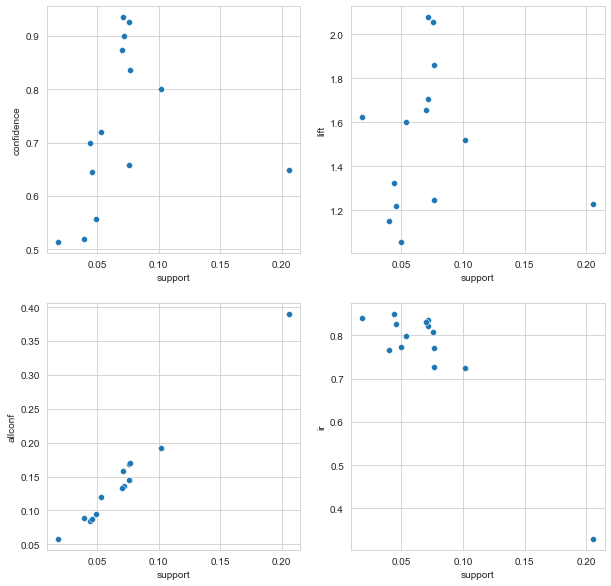

In [251]:
import seaborn as sns 
sns.set_style('whitegrid')
f, axs = plt.subplots(2,2, figsize=(10,10))
sns.scatterplot(x=ass_rule.support,y=ass_rule.confidence,ax=axs[0][0])
sns.scatterplot(x=ass_rule.support,y=ass_rule.lift,ax=axs[0][1])
sns.scatterplot(x=ass_rule.support,y=ass_rule.allconf,ax=axs[1][0])
sns.scatterplot(x=ass_rule.support,y=ass_rule.ir,ax=axs[1][1])
plt.show()

### 7.2 绘制各个规则的对应的评价指标的柱状图

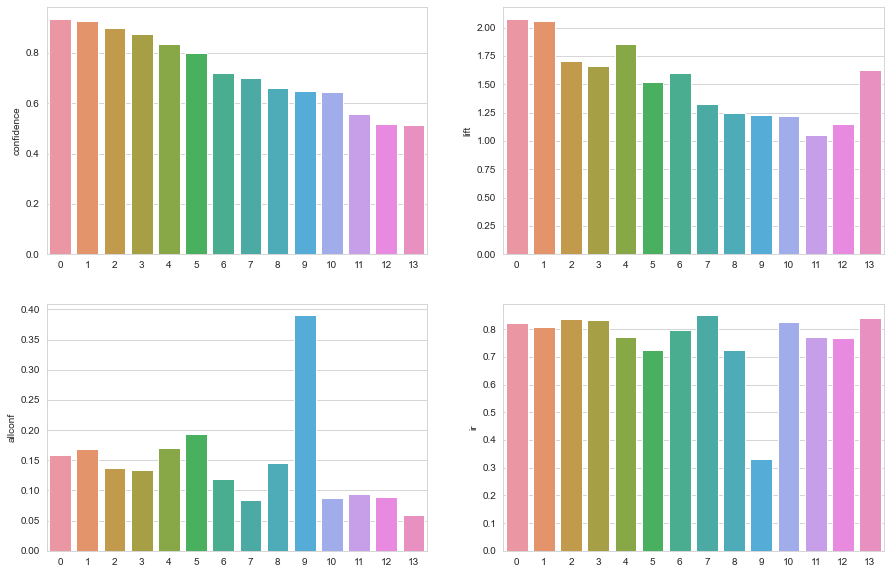

In [252]:
sns.set_style('whitegrid')
f, axs = plt.subplots(2,2, figsize=(15,10))
sns.barplot(x=ass_rule.index,y=ass_rule.confidence,ax=axs[0][0])
sns.barplot(x=ass_rule.index,y=ass_rule.lift,ax=axs[0][1])
sns.barplot(x=ass_rule.index,y=ass_rule.allconf,ax=axs[1][0])
sns.barplot(x=ass_rule.index,y=ass_rule.ir,ax=axs[1][1])
plt.show()

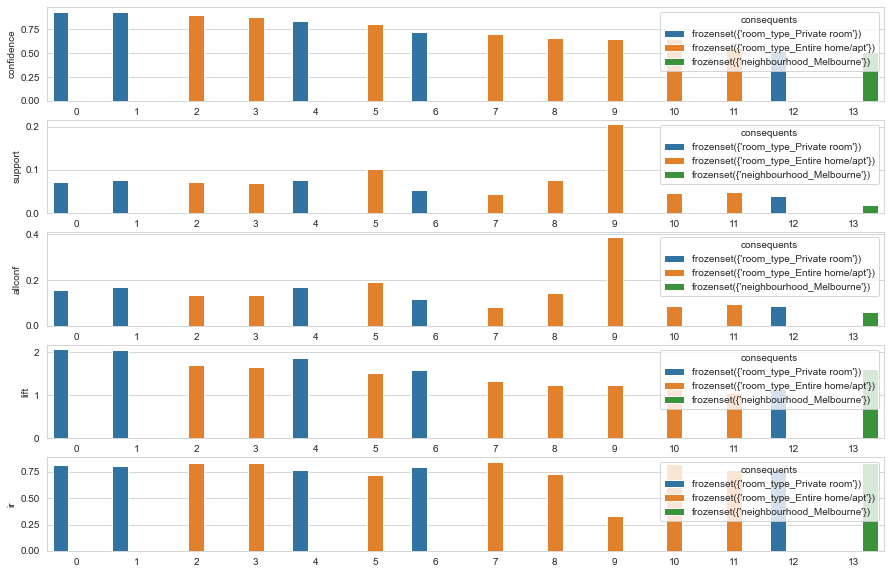

In [253]:
sns.set_style('whitegrid')
f, axs = plt.subplots(5,1, figsize=(15,10))
sns.barplot(x=ass_rule.index,y=ass_rule.confidence,hue='consequents',data=ass_rule,ax=axs[0])
sns.barplot(x=ass_rule.index,y=ass_rule.support,hue='consequents',data=ass_rule,ax=axs[1])
sns.barplot(x=ass_rule.index,y=ass_rule.allconf,hue='consequents',data=ass_rule,ax=axs[2])
sns.barplot(x=ass_rule.index,y=ass_rule.lift,hue='consequents',data=ass_rule,ax=axs[3])
sns.barplot(x=ass_rule.index,y=ass_rule.ir,hue='consequents',data=ass_rule,ax=axs[4])
plt.show()